## 05. PyTorch Going Modular

- https://www.learnpytorch.io/05_pytorch_going_modular/

- data_setup.py - a file to prepare and download data if needed.
- engine.py - a file containing various training functions.
- model_builder.py or model.py - a file to create a PyTorch model.
- train.py - a file to leverage all other files and train a target PyTorch model.
- utils.py - a file dedicated to helpful utility functions.

노트북은 실험하기에 좋은 환경이나,  
모듈 형태의 production 코드가 다른 사람과 공유하거나 서비스에 유용하다.

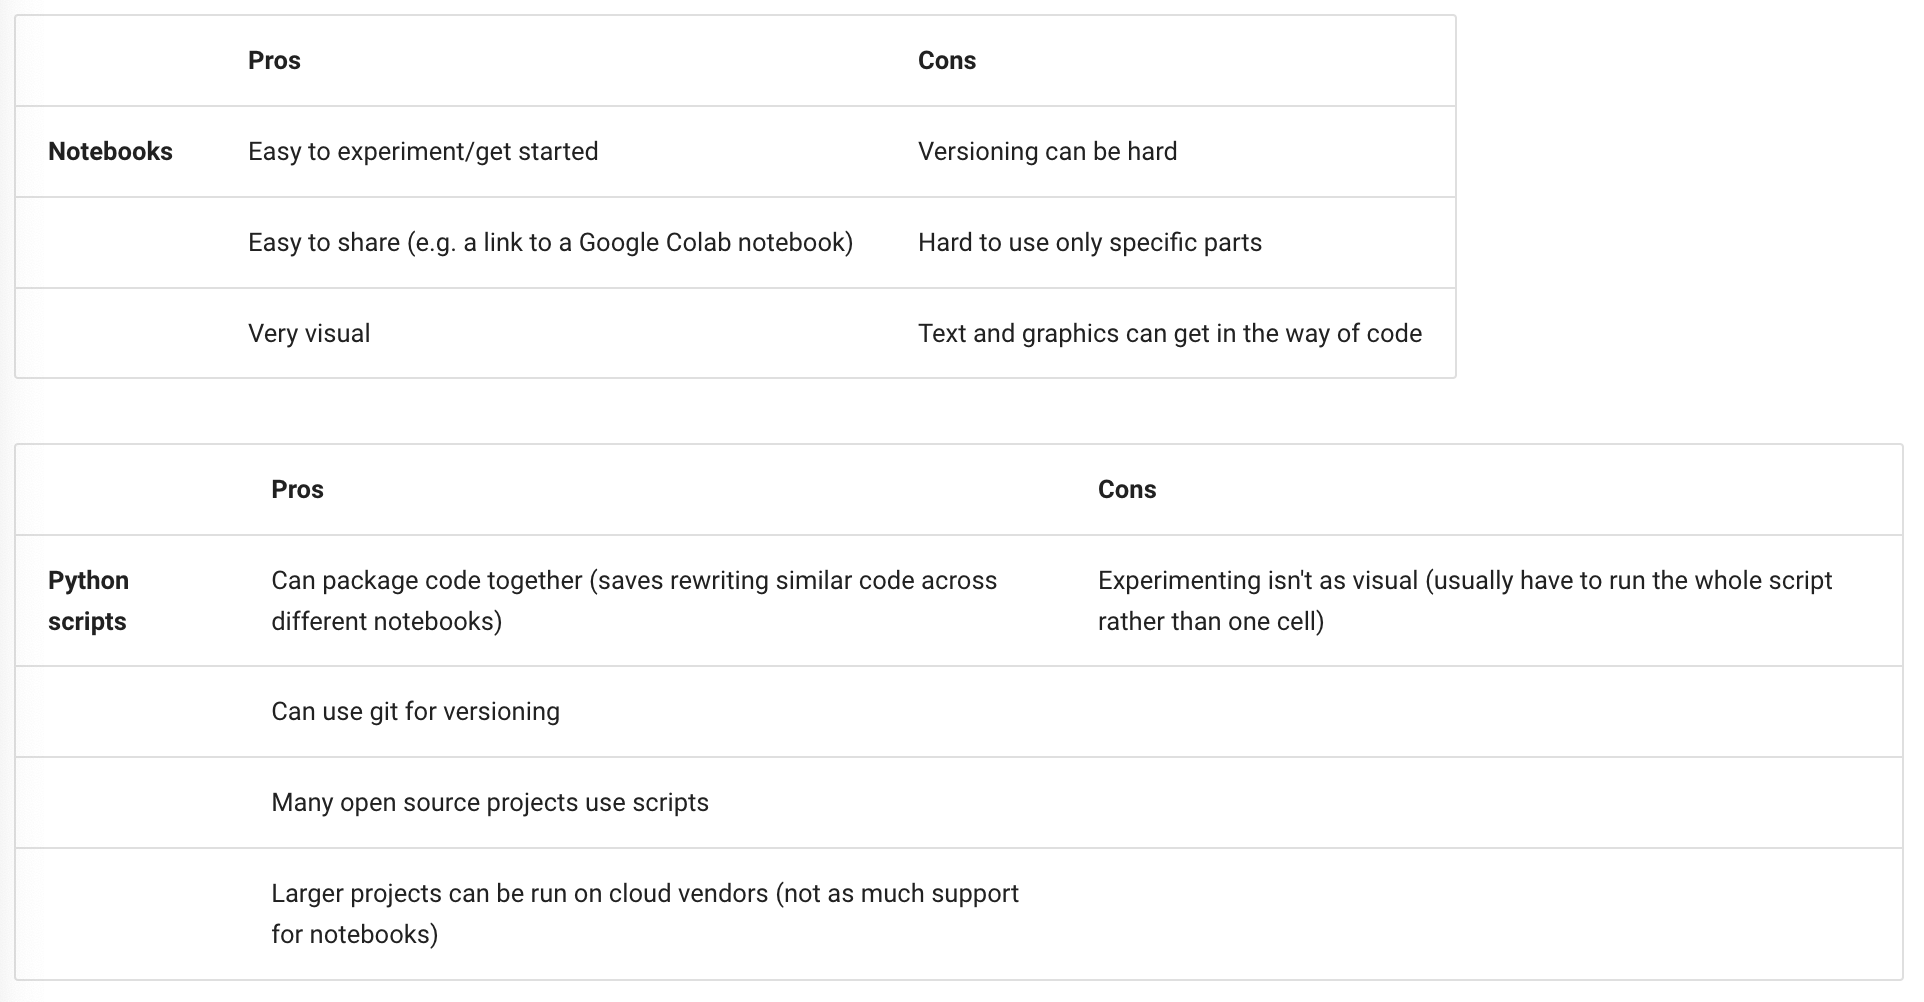

일반적으로 주피터에서 실험한 후 파이썬 스크립트로 정리한다.

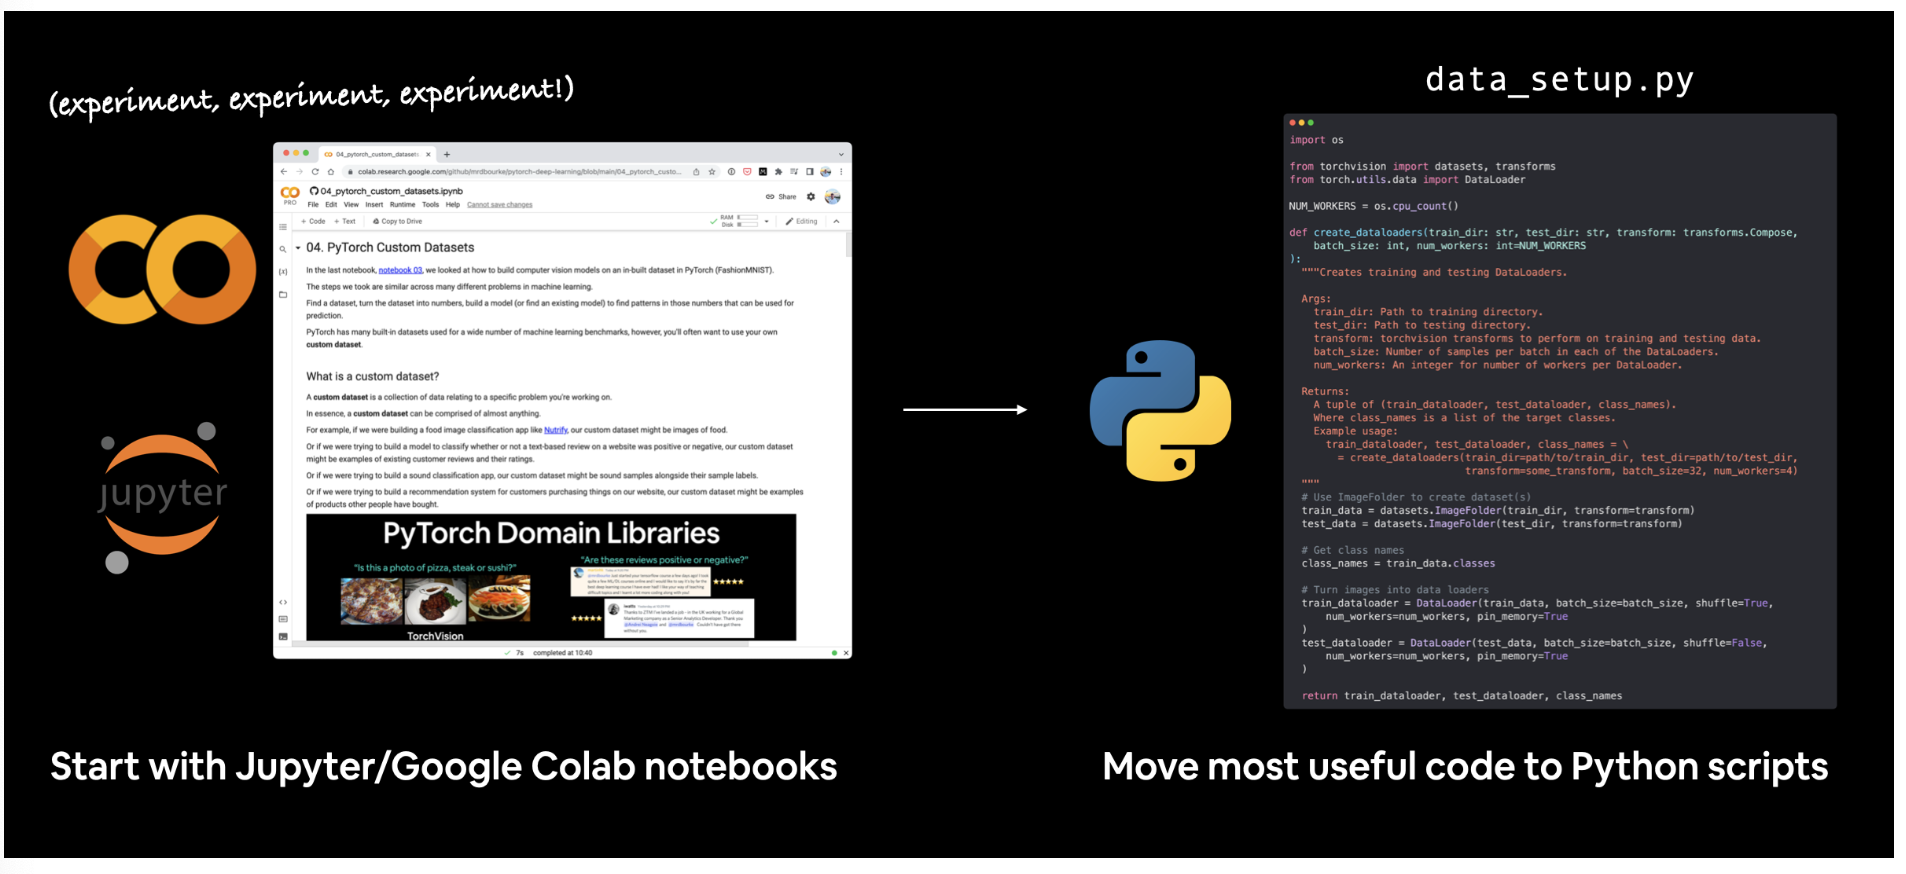

공개된 파이토치 저장소의 경우 학습을 진행할 때 다음처럼 하는 경우를 봤을 것이다.

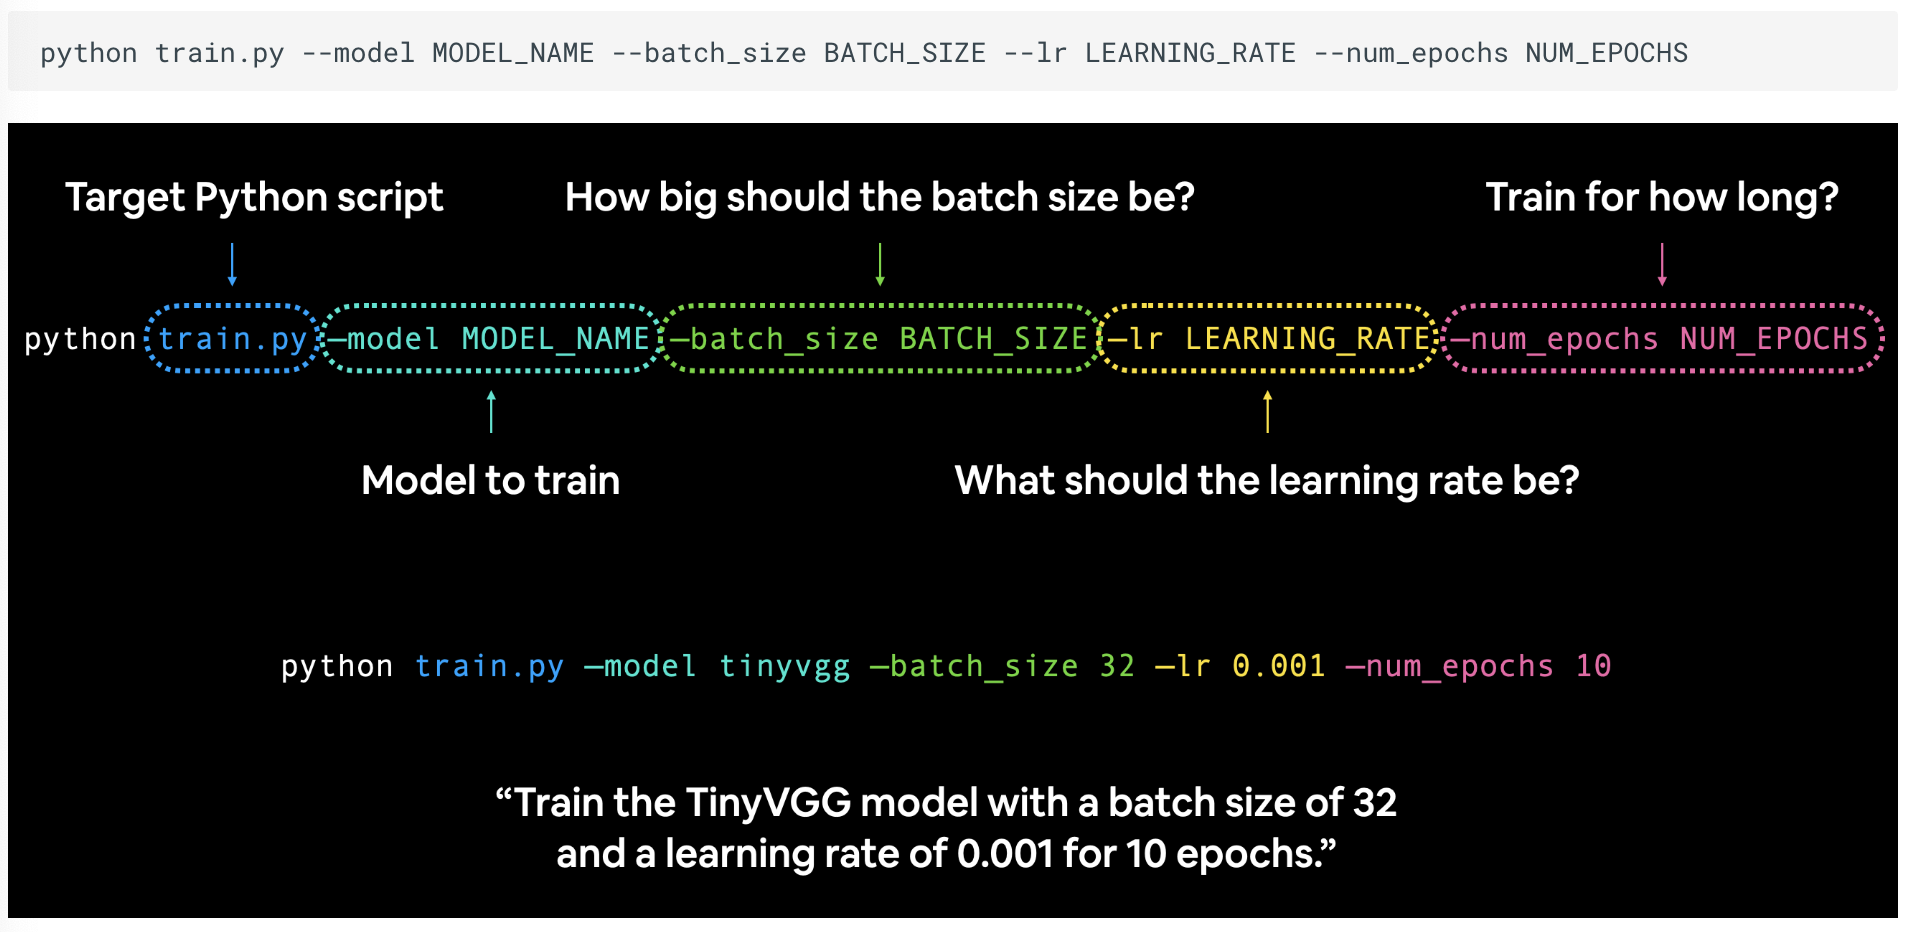

본 챕터의 세션 두가지  
- 05. Going Modular: Part 1 (cell mode) - this notebook is run as a traditional Jupyter Notebook/Google Colab notebook and is a condensed version of notebook 04.
- 05. Going Modular: Part 2 (script mode) - this notebook is the same as number 1 but with added functionality to turn each of the major sections into Python scripts, such as, data_setup.py and train.py.

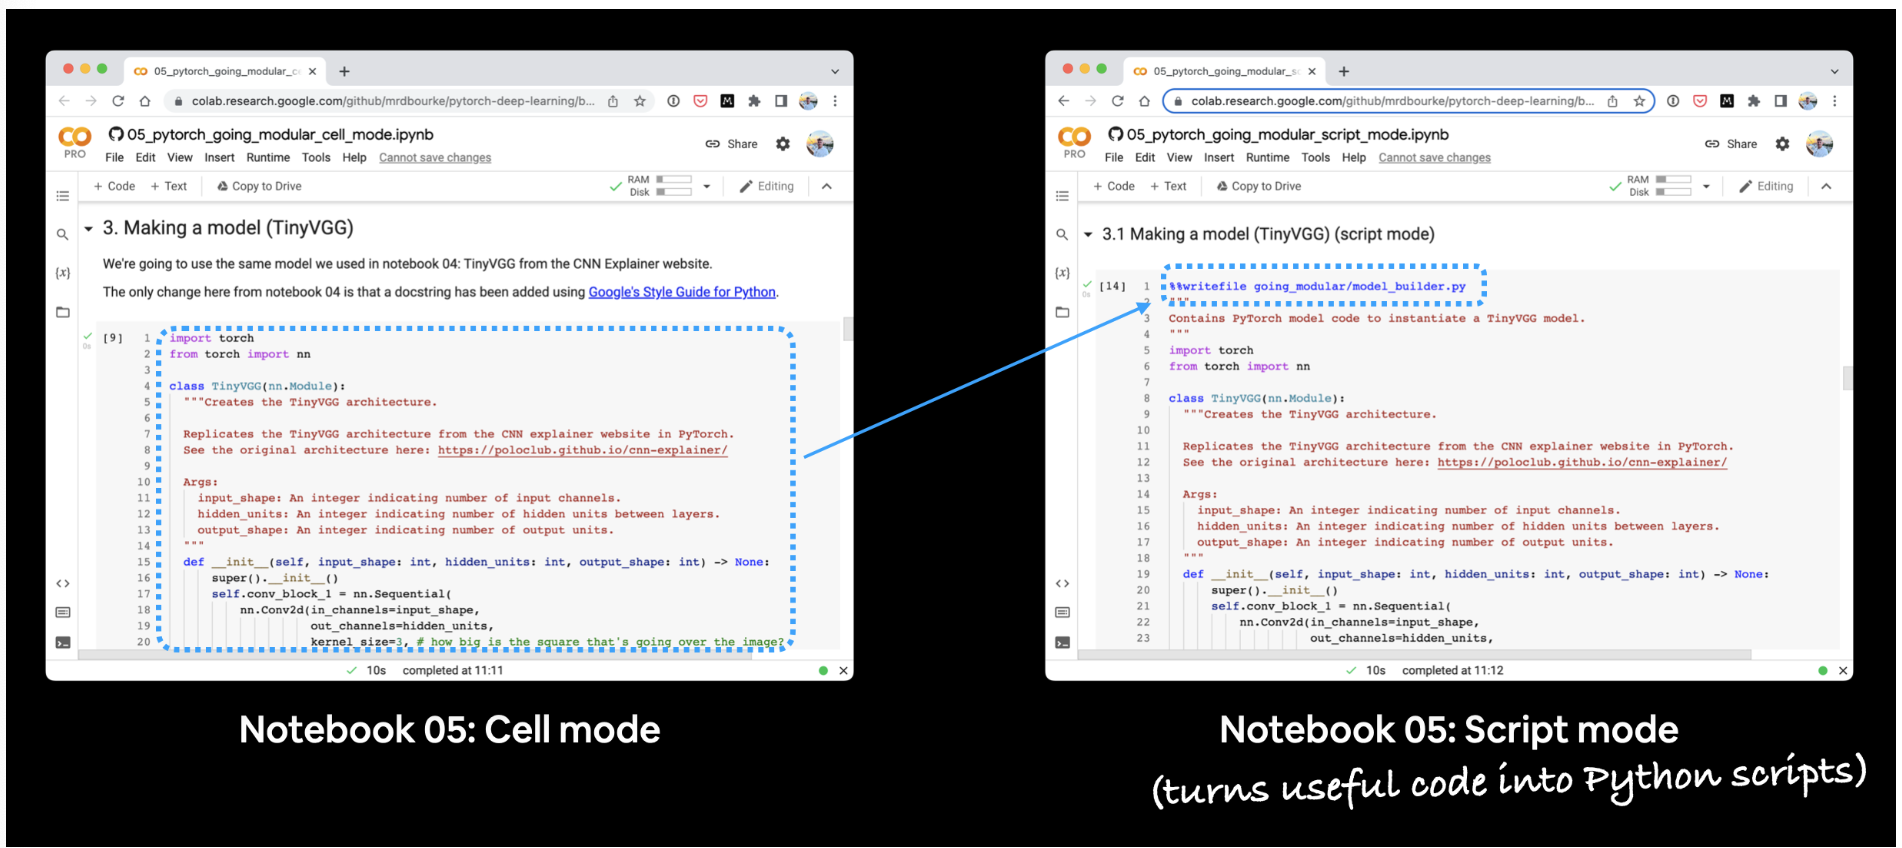

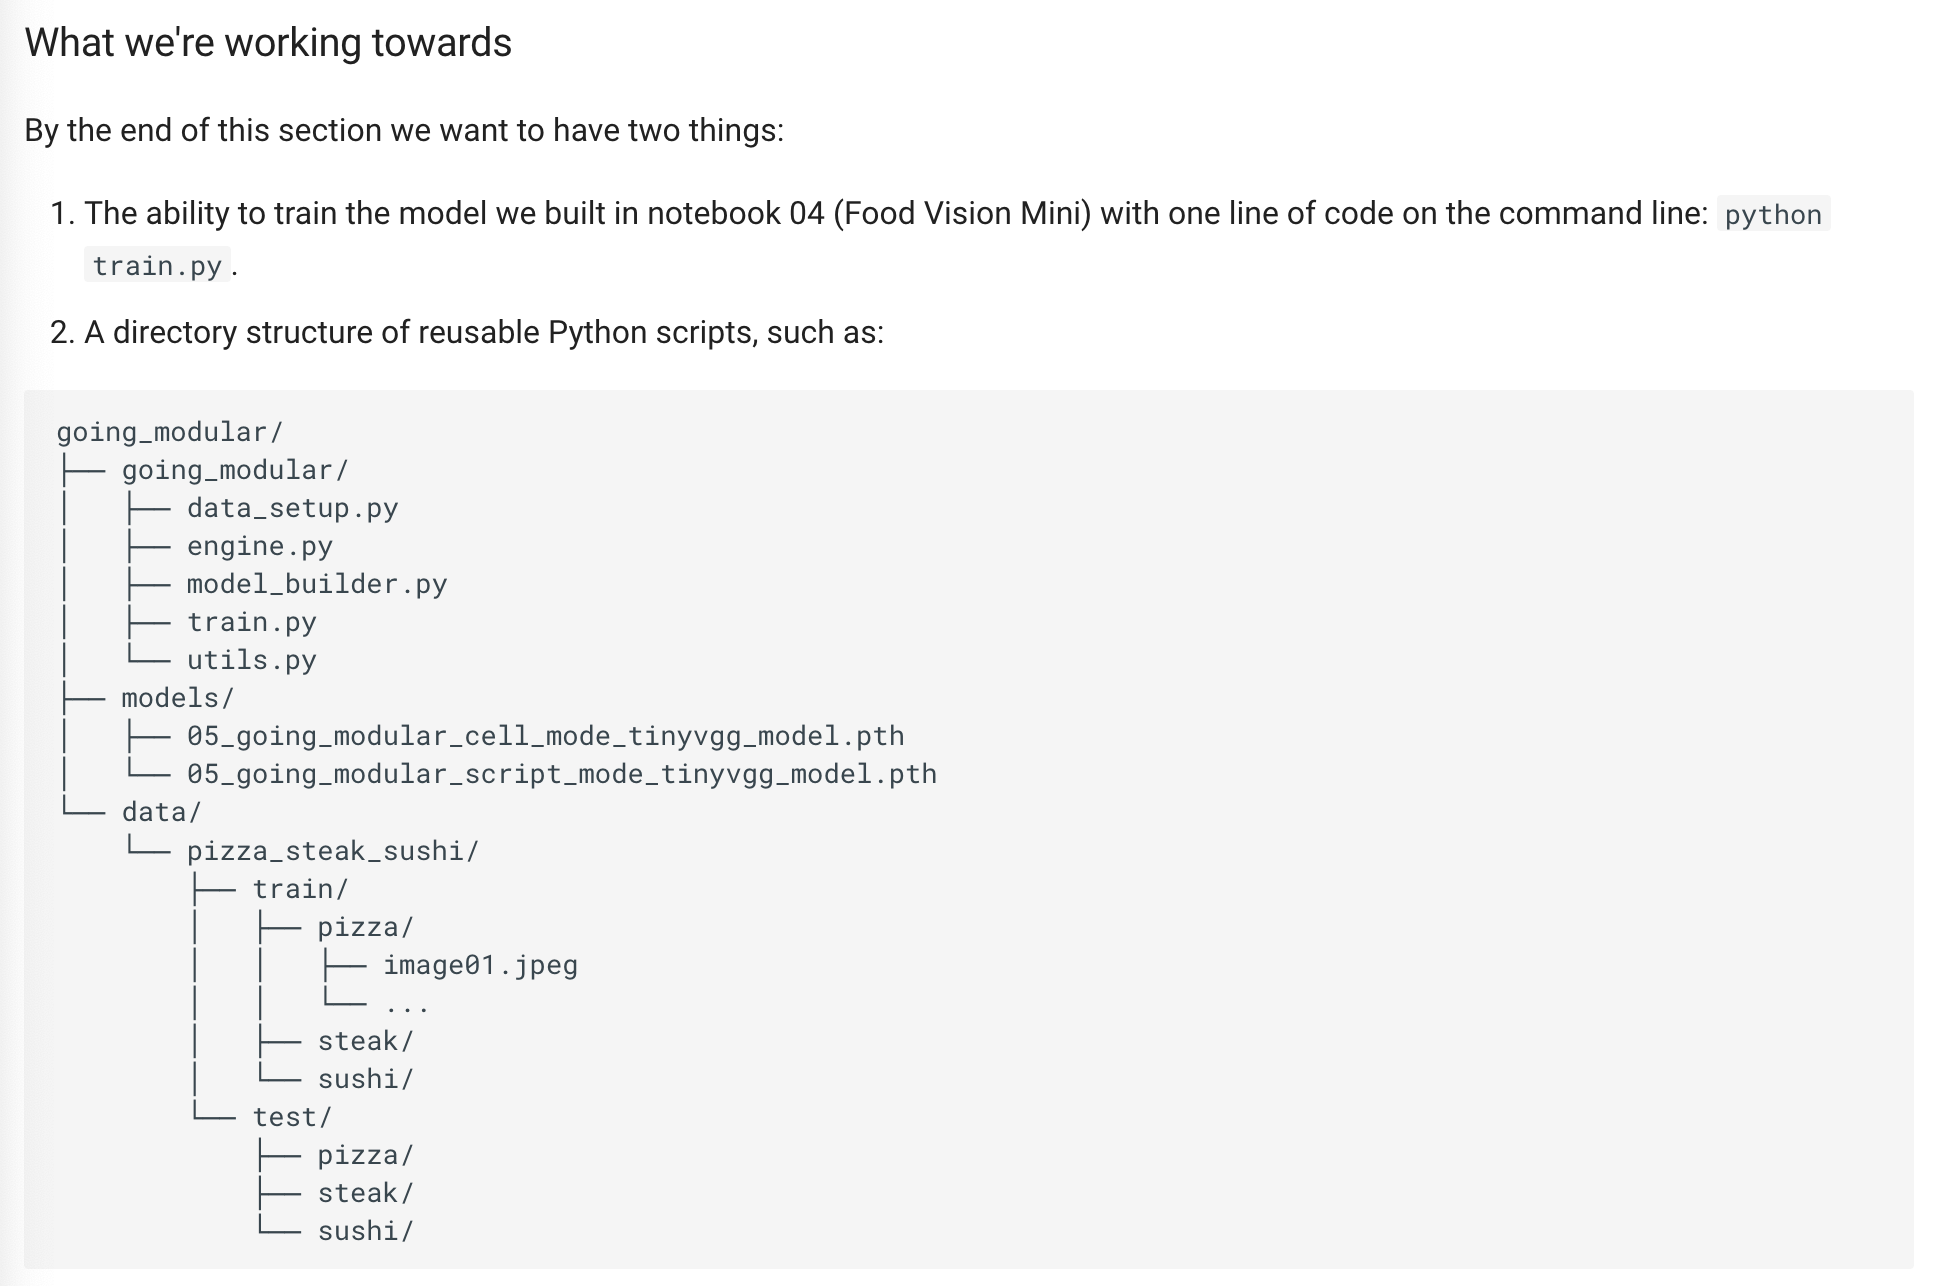

알아두면 좋은 점  
- Docstrings - Writing reproducible and understandable code is important. And with this in mind, each of the functions/classes we'll be putting into scripts has been created with Google's Python docstring style in mind.  
- Imports at the top of scripts - Since all of the Python scripts we're going to create could be considered a small program on their own, all of the scripts require their input modules be imported at the start of the script for example:

- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/05_pytorch_going_modular_cell_mode.ipynb
- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/05_pytorch_going_modular_script_mode.ipynb

위에서 두번째 노트북을 실행하면 스크립트 파일이 생성된다.!! **중요**
- 두번째 노트북 향후에 볼것

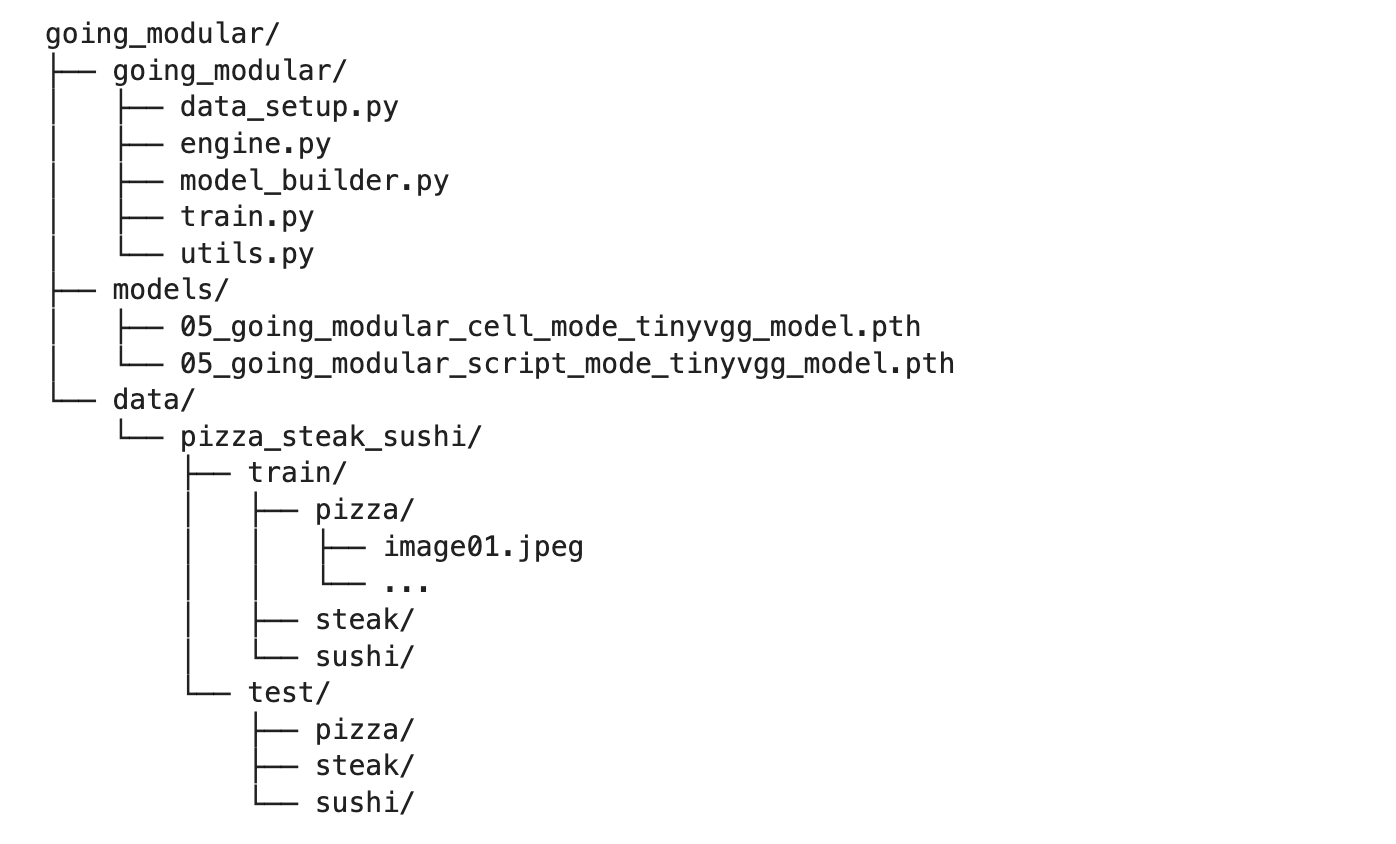

In [2]:
import os
os.listdir()

['05. PyTorch Going Modular.ipynb', '.ipynb_checkpoints']

### 1. Get data

In [3]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# 이미지 폴더가 없으면 다운로드,   
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one..")
    image_path.mkdir(parents=True, exist_ok=True)
    
# 데이터 다운로드
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)
    
# 압축풀기
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)
    
# 압축파일 삭제
os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one..
Unzipping pizza, steak, sushi data...


In [6]:
os.listdir('data/pizza_steak_sushi/train/')

['steak', 'sushi', 'pizza']

폴더 구조는 다음과 같다.

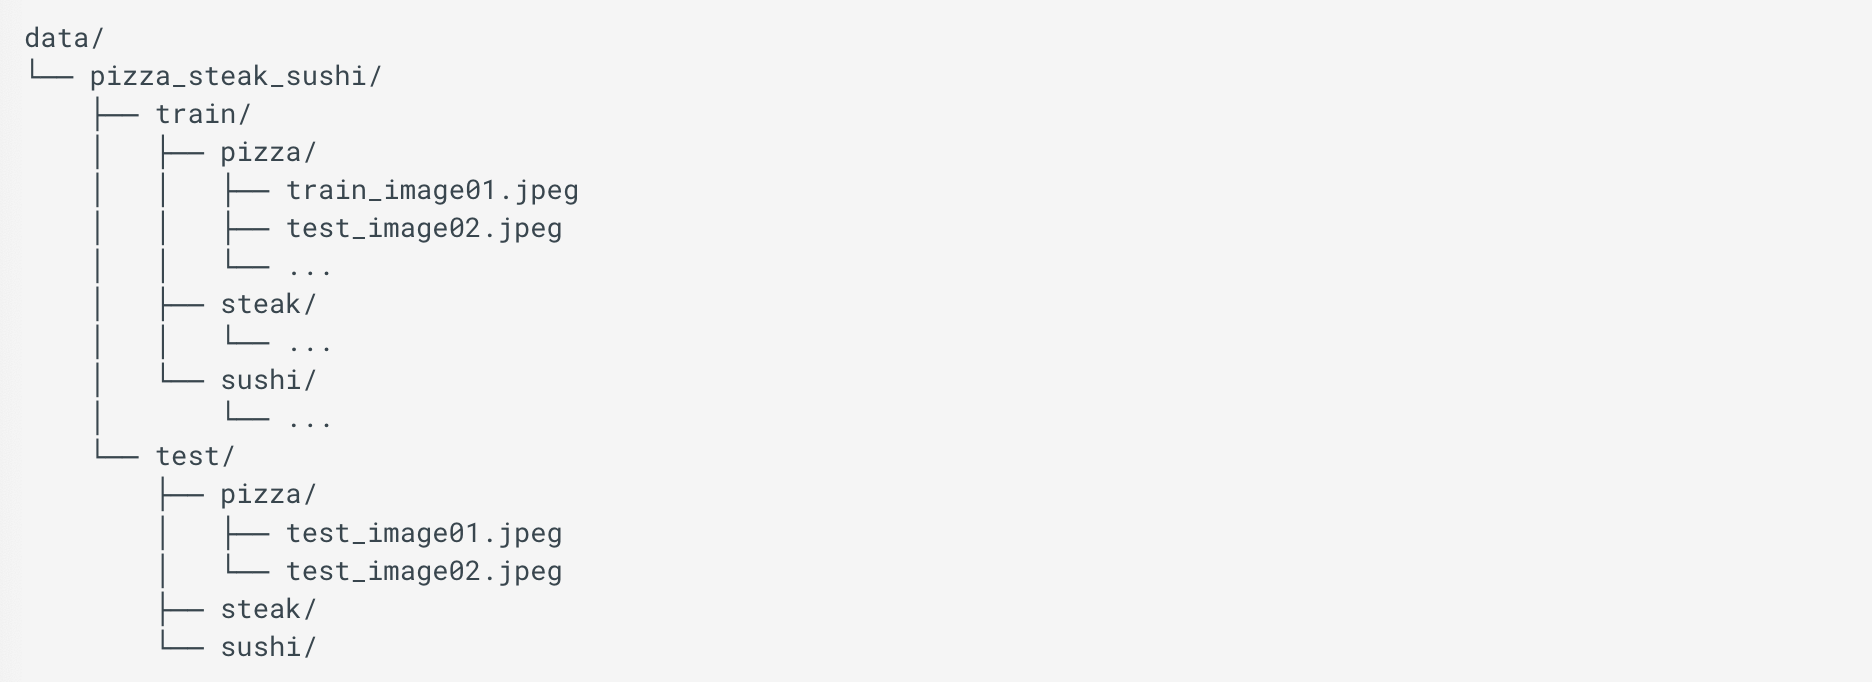

### 2. Create Datasets and DataLoaders (data_setup.py)

In [9]:
os.mkdir("going_modular")

In [10]:
%%writefile going_modular/data_setup.py

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
    
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    
    class_names = train_data.classes
    
    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


In [11]:
os.listdir('going_modular/')

['data_setup.py']

In [12]:
!cat going_modular/data_setup.py


import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create

이제 다음처럼 모듈을 불러와서 사용할 수있다.

```python
# Import data_setup.py
from going_modular import data_setup

# Create train/test dataloader and get class names as a list
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(...)
```

### 3. Making a model (model_builder.py)

In [13]:
!ls

05. PyTorch Going Modular.ipynb going_modular
data


In [15]:
%%writefile going_modular/model_builder.py

import torch
from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
      input_shape: An integer indicating number of input channels.
      hidden_units: An integer indicating number of hidden units between layers.
      output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                     kernel_size=3,
                     stride=1, 
                     padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3, 
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )
        
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

Writing going_modular/model_builder.py


이제 모듈을 다음과 같이 불러와서 사용하면 된다.  

```python
import torch
# Import model_builder.py
from going_modular import model_builder
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
torch.manual_seed(42)
model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=10, 
                              output_shape=len(class_names)).to(device)
```

### 4. Creating train_step() and test_step() functions and train() to combine them

- 1. train_step() - takes in `a model`, `a DataLoader`, `a loss function` and `an optimizer` and trains the model on the DataLoader.
- 2. test_step() - takes in `a model`, `a DataLoader` and `a loss function` and evaluates the model on the DataLoader.
- 3. train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [16]:
%%writefile going_modular/engine.py

import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
      model: A PyTorch model to be trained.
      dataloader: A DataLoader instance for the model to be trained on.
      loss_fn: A PyTorch loss function to minimize.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A tuple of training loss and training accuracy metrics.
      In the form (train_loss, train_accuracy). For example:

      (0.1112, 0.8743)
    """
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # 추후 활용위해 item을 저장
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        # 배치 내에서 accuracy metric 계산 누적
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
      model: A PyTorch model to be tested.
      dataloader: A DataLoader instance for the model to be tested on.
      loss_fn: A PyTorch loss function to calculate loss on the test data.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A tuple of testing loss and testing accuracy metrics.
      In the form (test_loss, test_accuracy). For example:

      (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         epochs: int,
         device: torch.device) -> Dict[str, str]: # 리턴힌트 수정요
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
      For example if training for epochs=2: 
                   {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]} 
    """    
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
              }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

Writing going_modular/engine.py


사용예
```python
# Import engine.py
from going_modular import engine

# Use train() by calling it from engine.py
engine.train(...)
```

### 5. Creating a function to save the model (utils.py)

In [17]:
%%writefile going_modular/utils.py

import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
              target_dir: str,
              model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
      model: A target PyTorch model to save.
      target_dir: A directory for saving the model to.
      model_name: A filename for the saved model. Should include
        either ".pth" or ".pt" as the file extension.

    Example usage:
      save_model(model=model_0,
                 target_dir="models",
                 model_name="05_going_modular_tingvgg_model.pth")
    """
    
    # Create target dir
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)
    
    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name
    
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj = model.state_dict(),
              f=mode_save_path)

Writing going_modular/utils.py


In [18]:
os.listdir('going_modular/')

['model_builder.py', 'engine.py', 'data_setup.py', 'utils.py']

```python
# Import utils.py
from going_modular import utils

# Save a model to file
save_model(model=...
           target_dir=...,
           model_name=...)
```

### 6. Train, evaluate and save the model (train.py)

- 1) Import the various dependencies
- 2) Note: Since train.py will be inside the going_modular directory, we can import the other modules via import ... rather than from going_modular import ....
- 3) Setup various hyperparameters such as batch size, number of epochs, learning rate and number of hidden units (these could be set in the future via Python's argparse).
- 4) Setup the training and test directories.
- 5) Setup device-agnostic code.
- 6) Create the necessary data transforms.
- 7) Create the DataLoaders using data_setup.py.
- 8) Create the model using model_builder.py.
- 9) Setup the loss function and optimizer.
- 10) Train the model using engine.py.
- 11) Save the model using utils.py.

In [20]:
%%writefile going_modular/train.py

import os
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Writing going_modular/train.py


argparse 모듈을 사용하면 다음과 같이 명령을 사용할 수 있다.

```sh
python train.py --model MODEL_NAME --batch_size BATCH_SIZE --lr LEARNING_RATE --num_epochs NUM_EPOCHS
```